# Spatial Join & Nearest Neighbor

In [31]:
import geopandas as gpd
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint, LineString
import shapely.speedups
shapely.speedups.enable()

# Import KML drivers (read/write)
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
%matplotlib inline

In [2]:
# Filepath
fp = r'data/Vaestotietoruudukko_2015.shp'
adr_fp = r'data/addresses_geocode.shp'

# Read data
adrs = gpd.read_file(adr_fp)

pop = gpd.read_file(fp)
pop.head()



,ASUKKAITA,ASVALJYYS,IKA0_9,IKA10_19,IKA20_29,IKA30_39,IKA40_49,IKA50_59,IKA60_69,IKA70_79,IKA_YLI80,INDEX,geometry
0,8,31.0,99,99,99,99,99,99,99,99,99,688,"POLYGON ((25472499.99532626 6689749.005069185,..."
1,6,42.0,99,99,99,99,99,99,99,99,99,703,"POLYGON ((25472499.99532626 6685998.998064222,..."
2,8,44.0,99,99,99,99,99,99,99,99,99,710,"POLYGON ((25472499.99532626 6684249.004130407,..."
3,7,64.0,99,99,99,99,99,99,99,99,99,711,"POLYGON ((25472499.99532626 6683999.004997005,..."
4,19,23.0,99,99,99,99,99,99,99,99,99,715,"POLYGON ((25472499.99532626 6682998.998461431,..."


In [3]:
# Rename columns
pop = pop.rename(columns={'ASUKKAITA': 'POP15'})
pop.columns

Index(['POP15', 'ASVALJYYS', 'IKA0_9', 'IKA10_19', 'IKA20_29', 'IKA30_39',
       'IKA40_49', 'IKA50_59', 'IKA60_69', 'IKA70_79', 'IKA_YLI80', 'INDEX',
       'geometry'],
      dtype='object')

In [4]:
drop_cols = ['ASVALJYYS', 'IKA0_9', 'IKA10_19', 'IKA20_29', 'IKA30_39',
       'IKA40_49', 'IKA50_59', 'IKA60_69', 'IKA70_79', 'IKA_YLI80', 'INDEX']
pop = pop.drop(labels=drop_cols, axis=1)
pop.head()

,POP15,geometry
0,8,"POLYGON ((25472499.99532626 6689749.005069185,..."
1,6,"POLYGON ((25472499.99532626 6685998.998064222,..."
2,8,"POLYGON ((25472499.99532626 6684249.004130407,..."
3,7,"POLYGON ((25472499.99532626 6683999.004997005,..."
4,19,"POLYGON ((25472499.99532626 6682998.998461431,..."


In [5]:
adrs.crs = from_epsg(4326)

In [6]:
# Check CRS
print(pop.crs, '\n\n', adrs.crs)

{'no_defs': True, 'proj': 'tmerc', 'lat_0': 0, 'lon_0': 25, 'ellps': 'GRS80', 'y_0': 0, 'x_0': 25500000, 'units': 'm', 'k': 1} 

 {'no_defs': True, 'init': 'epsg:4326'}


In [7]:
# Reproject addresses to same projection as population dataset
adrs = adrs.to_crs(crs=pop.crs)
adrs.crs

{'ellps': 'GRS80',
 'k': 1,
 'lat_0': 0,
 'lon_0': 25,
 'no_defs': True,
 'proj': 'tmerc',
 'units': 'm',
 'x_0': 25500000,
 'y_0': 0}

In [8]:
# Check if CRSs are the same
adrs.crs == pop.crs

True

In [9]:
adrs.head()

,addr,address,geometry,id
0,"Itämerenkatu 14, 00101 Helsinki, Finland","Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",POINT (25495311.78001142 6672258.582999197),1000
1,"Kampinkuja 1, 00100 Helsinki, Finland","Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",POINT (25496207.84010911 6672906.172794735),1001
2,"Kaivokatu 8, 00101 Helsinki, Finland","Citycenter, 8, Kaivokatu, Keskusta, Kluuvi, Et...",POINT (25496804.66082322 6673001.671884767),1002
3,"Hermannin rantatie 1, 00580 Helsinki, Finland","Hermannin rantatie, Kyläsaari, Hermanni, Helsi...",POINT (25498388.53457338 6676083.994075484),1003
4,"Tyynenmerenkatu 9, 00220 Helsinki, Finland","Hesburger Jätkäsaari, 9, Tyynenmerenkatu, Jätk...",POINT (25495643.76901715 6671533.429514003),1005


In [10]:
# Spatial join: 
join = gpd.sjoin(adrs, pop, how='inner', op='within')
join.head()

,addr,address,geometry,id,index_right,POP15
0,"Itämerenkatu 14, 00101 Helsinki, Finland","Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",POINT (25495311.78001142 6672258.582999197),1000,3214,521
1,"Kampinkuja 1, 00100 Helsinki, Finland","Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",POINT (25496207.84010911 6672906.172794735),1001,3326,173
2,"Kaivokatu 8, 00101 Helsinki, Finland","Citycenter, 8, Kaivokatu, Keskusta, Kluuvi, Et...",POINT (25496804.66082322 6673001.671884767),1002,3449,31
10,"Rautatientori 1, 00100 Helsinki, Finland","Rautatientori, Keskusta, Kluuvi, Eteläinen suu...",POINT (25496896.60078502 6673159.446016792),1011,3449,31
3,"Hermannin rantatie 1, 00580 Helsinki, Finland","Hermannin rantatie, Kyläsaari, Hermanni, Helsi...",POINT (25498388.53457338 6676083.994075484),1003,3721,284


C:\Users\Camilo\Anaconda3\envs\geopython\lib\site-packages\geopandas\geodataframe.py:447: UserWarning: Unrecognized scheme "natural_breaks". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)


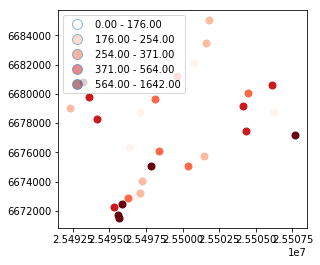

In [11]:
join.plot(column='POP15', cmap='Reds', markersize=7, scheme='natural_breaks',\
          legend=True)

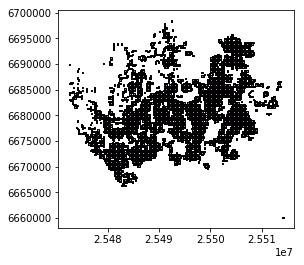

In [12]:
pop.plot(column='POP15')

## Nearest Neighbour Analysis

In [13]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

In [14]:
# Create origin point
orig = Point(1, 1.67)

# Create other points
dest1, dest2, dest3 = Point(0, 1.45), Point(2, 2), Point(0, 2.5)

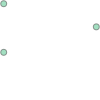

In [15]:
# Create MultiPoint object
dest = MultiPoint([dest1, dest2, dest3])
dest

In [16]:
# Calculate the nearest geometry
near_geom = nearest_points(orig, dest)
print(near_geom[0], '\n', near_geom[1])

POINT (1 1.67) 
 POINT (0 1.45)


## Nearest points using Geopandas

In [17]:
def nearest(row, geom_union, df1, df2, geom1_col='geometry', 
            geom2_col='geometry', src_column=None):
    """Find the nearest point and return the corresponding 
    value from specified column."""
    
    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]
    
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = df2[nearest][src_column].get_values()[0]
    
    return value

In [18]:
# Filepaths
adr_fp = r'data/addresses_geocode.shp'
poly_fp = r'data/PKS_suuralue.kml'

# Read data
adrs = gpd.read_file(adr_fp)
polys = gpd.read_file(poly_fp, driver='KML')

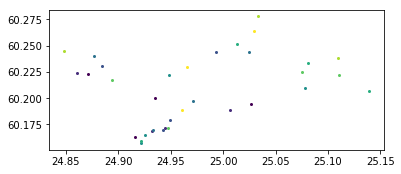

In [19]:
adrs.plot()

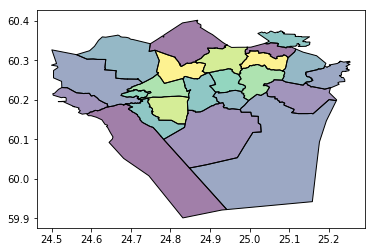

In [20]:
polys.plot()

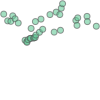

In [21]:
# Create MultiPoint object
unary_union = adr
s.unary_union
unary_union

In [22]:
# Calculate polygons centroid
polys['centroid'] = polys.centroid
polys.head()

,Description,Name,geometry,centroid
0,,Suur-Espoonlahti,POLYGON Z ((24.775059677807 60.1090604462157 0...,POINT (24.76754037242762 60.0440879200116)
1,,Suur-Kauklahti,POLYGON Z ((24.6157775254076 60.1725681273527 ...,POINT (24.57415010885406 60.19764302289445)
2,,Vanha-Espoo,POLYGON Z ((24.6757633262026 60.2120070032819 ...,POINT (24.60400724339237 60.25253297356344)
3,,Pohjois-Espoo,POLYGON Z ((24.767921197401 60.2691954732391 0...,POINT (24.68682879841453 60.30649462398335)
4,,Suur-Matinkylä,POLYGON Z ((24.7536131356802 60.1663051341717 ...,POINT (24.76063843560942 60.15018263640097)


In [23]:
polys['nearest_id'] = polys.apply(nearest, geom_union=unary_union, df1=polys,
                            df2=adrs, geom1_col='centroid', src_column='id',
                            axis=1)
polys.head()

,Description,Name,geometry,centroid,nearest_id
0,,Suur-Espoonlahti,POLYGON Z ((24.775059677807 60.1090604462157 0...,POINT (24.76754037242762 60.0440879200116),1000
1,,Suur-Kauklahti,POLYGON Z ((24.6157775254076 60.1725681273527 ...,POINT (24.57415010885406 60.19764302289445),1017
2,,Vanha-Espoo,POLYGON Z ((24.6757633262026 60.2120070032819 ...,POINT (24.60400724339237 60.25253297356344),1017
3,,Pohjois-Espoo,POLYGON Z ((24.767921197401 60.2691954732391 0...,POINT (24.68682879841453 60.30649462398335),1017
4,,Suur-Matinkylä,POLYGON Z ((24.7536131356802 60.1663051341717 ...,POINT (24.76063843560942 60.15018263640097),1020


In [24]:
# Rename Polygon geometry
polys = polys.rename(columns={'geometry': 'poly_geom'})
polys.head()

,Description,Name,poly_geom,centroid,nearest_id
0,,Suur-Espoonlahti,POLYGON Z ((24.775059677807 60.1090604462157 0...,POINT (24.76754037242762 60.0440879200116),1000
1,,Suur-Kauklahti,POLYGON Z ((24.6157775254076 60.1725681273527 ...,POINT (24.57415010885406 60.19764302289445),1017
2,,Vanha-Espoo,POLYGON Z ((24.6757633262026 60.2120070032819 ...,POINT (24.60400724339237 60.25253297356344),1017
3,,Pohjois-Espoo,POLYGON Z ((24.767921197401 60.2691954732391 0...,POINT (24.68682879841453 60.30649462398335),1017
4,,Suur-Matinkylä,POLYGON Z ((24.7536131356802 60.1663051341717 ...,POINT (24.76063843560942 60.15018263640097),1020


In [25]:
adrs.head()

,addr,address,geometry,id
0,"Itämerenkatu 14, 00101 Helsinki, Finland","Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",POINT (24.9155655 60.1632005),1000
1,"Kampinkuja 1, 00100 Helsinki, Finland","Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",POINT (24.9316914 60.1690222),1001
2,"Kaivokatu 8, 00101 Helsinki, Finland","Citycenter, 8, Kaivokatu, Keskusta, Kluuvi, Et...",POINT (24.94244049213 60.16988445),1002
3,"Hermannin rantatie 1, 00580 Helsinki, Finland","Hermannin rantatie, Kyläsaari, Hermanni, Helsi...",POINT (24.9709473 60.1975589),1003
4,"Tyynenmerenkatu 9, 00220 Helsinki, Finland","Hesburger Jätkäsaari, 9, Tyynenmerenkatu, Jätk...",POINT (24.9215601 60.1566956),1005


In [28]:
# Table join
polys = polys.merge(adrs, left_on='nearest_id', right_on='id')
polys.head()

,Description,Name,poly_geom,centroid,nearest_id,addr_x,address_x,geometry_x,id_x,addr_y,address_y,geometry_y,id_y
0,,Suur-Espoonlahti,POLYGON Z ((24.775059677807 60.1090604462157 0...,POINT (24.76754037242762 60.0440879200116),1000,"Itämerenkatu 14, 00101 Helsinki, Finland","Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",POINT (24.9155655 60.1632005),1000,"Itämerenkatu 14, 00101 Helsinki, Finland","Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",POINT (24.9155655 60.1632005),1000
1,,Suur-Kauklahti,POLYGON Z ((24.6157775254076 60.1725681273527 ...,POINT (24.57415010885406 60.19764302289445),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017
2,,Vanha-Espoo,POLYGON Z ((24.6757633262026 60.2120070032819 ...,POINT (24.60400724339237 60.25253297356344),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017
3,,Pohjois-Espoo,POLYGON Z ((24.767921197401 60.2691954732391 0...,POINT (24.68682879841453 60.30649462398335),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017
4,,Kauniainen,POLYGON Z ((24.6907528033566 60.2195779731868 ...,POINT (24.71357964516679 60.21457067576294),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017


In [33]:
# Create a linestring from the centroids to the address points
polys['line'] = None
polys['line'] = polys.apply(lambda row: LineString([row['geometry_y'], row['centroid']]), axis=1)
polys.head()

,Description,Name,poly_geom,centroid,nearest_id,addr_x,address_x,geometry_x,id_x,addr_y,address_y,geometry_y,id_y,line
0,,Suur-Espoonlahti,POLYGON Z ((24.775059677807 60.1090604462157 0...,POINT (24.76754037242762 60.0440879200116),1000,"Itämerenkatu 14, 00101 Helsinki, Finland","Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",POINT (24.9155655 60.1632005),1000,"Itämerenkatu 14, 00101 Helsinki, Finland","Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",POINT (24.9155655 60.1632005),1000,"LINESTRING (24.9155655 60.1632005, 24.76754037..."
1,,Suur-Kauklahti,POLYGON Z ((24.6157775254076 60.1725681273527 ...,POINT (24.57415010885406 60.19764302289445),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"LINESTRING (24.8486036 60.2451764, 24.57415010..."
2,,Vanha-Espoo,POLYGON Z ((24.6757633262026 60.2120070032819 ...,POINT (24.60400724339237 60.25253297356344),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"LINESTRING (24.8486036 60.2451764, 24.60400724..."
3,,Pohjois-Espoo,POLYGON Z ((24.767921197401 60.2691954732391 0...,POINT (24.68682879841453 60.30649462398335),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"LINESTRING (24.8486036 60.2451764, 24.68682879..."
4,,Kauniainen,POLYGON Z ((24.6907528033566 60.2195779731868 ...,POINT (24.71357964516679 60.21457067576294),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"Malminkartanontie 17, 00410 Helsinki, Finland","Malminkartanontie, Malminkartano, Konala, Hels...",POINT (24.8486036 60.2451764),1017,"LINESTRING (24.8486036 60.2451764, 24.71357964..."


In [42]:
# Visualizing the lines
lines = polys[['line', 'id_y']]
lines = lines.rename(columns={'line': 'geometry', 'id_y':'id'})
lines = gpd.GeoDataFrame(lines, crs=polys.crs)
print(type(lines))
lines.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry,id
0,"LINESTRING (24.9155655 60.1632005, 24.76754037...",1000
1,"LINESTRING (24.8486036 60.2451764, 24.57415010...",1017
2,"LINESTRING (24.8486036 60.2451764, 24.60400724...",1017
3,"LINESTRING (24.8486036 60.2451764, 24.68682879...",1017
4,"LINESTRING (24.8486036 60.2451764, 24.71357964...",1017


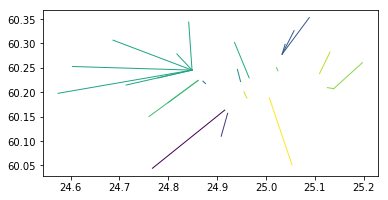

In [43]:
lines.plot(column='id')